In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_train = pd.read_csv("train_data_full.csv")
df_test = pd.read_csv("test_data_full.csv")

X = df_train[['a1', 'a2', 'a3', 'a4', 'a5', 'a6']]
y = df_train['Class']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

X_test = df_test[['a1', 'a2', 'a3', 'a4', 'a5', 'a6']]
y_test = df_test['Class']

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 207
Validation size: 208
Test size: 1296


In [2]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

param_grid_ripper = {
    'max_rules': [None, 10, 20],
    'max_rule_conds': [None, 3, 5],
    'min_samples_leaf': [1, 2, 5],
    'random_state': [42]
}




========== Decision Tree ==========
Number of hyperparameter combinations: 216
Best hyperparameter combination: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}

Macro-average Metrics:
Accuracy: 0.55, Precision: 0.53, Recall: 0.52, F1: 0.50

========== Random Forest ==========
Number of hyperparameter combinations: 432
Best hyperparameter combination: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Macro-average Metrics:
Accuracy: 0.56, Precision: 0.55, Recall: 0.54, F1: 0.53

========== RIPPER ==========
Number of hyperparameter combinations: 27
Best hyperparameter combination: {'max_rule_conds': None, 'max_rules': None, 'min_samples_leaf': 1, 'random_state': 42}

Macro-average Metrics:
Accuracy: 0.54, Precision: 0.53, Recall: 0.52, F1: 0.51

Final Summary Table:
        Model  Hyperparameter Combinations                                    

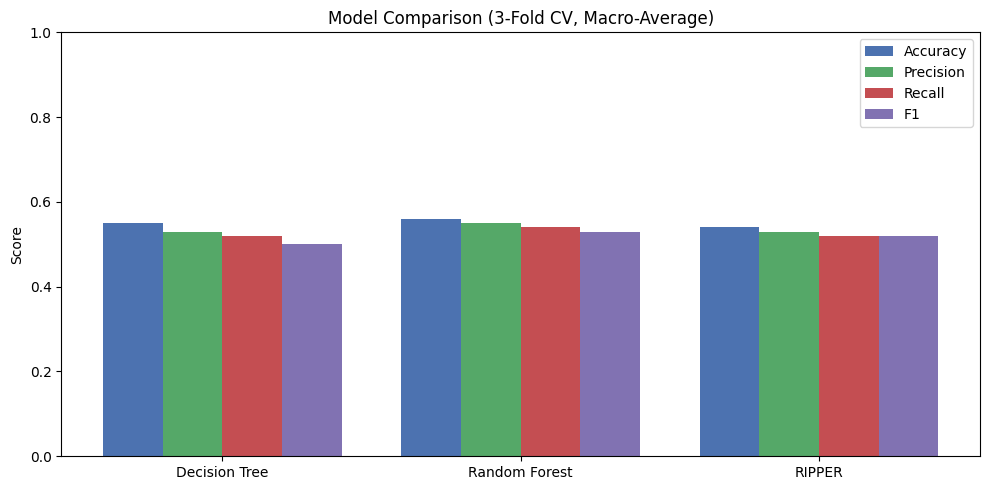

In [9]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import wittgenstein as lw
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

model_configs = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42), param_grid_dt),
    ("Random Forest", RandomForestClassifier(random_state=42), param_grid_rf),
    ("RIPPER", lw.RIPPER(), param_grid_ripper)
]

summary = []

for model_name, model, param_grid in model_configs:
    print(f"\n{'='*10} {model_name} {'='*10}")

    n_comb = len(list(ParameterGrid(param_grid)))
    print(f"Number of hyperparameter combinations: {n_comb}")

    gs = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_
    best_params = gs.best_params_
    print("Best hyperparameter combination:", best_params)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    y_pred = cross_val_predict(best_model, X_train, y_train, cv=cv)

    acc = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_train, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_train, y_pred, average='macro', zero_division=0)

    print(f"\nMacro-average Metrics:")
    print(f"Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    summary.append({
        "Model": model_name,
        "Hyperparameter Combinations": n_comb,
        "Best Hyperparameters": best_params,
        "Accuracy": round(acc, 4),
        "Precision (macro)": round(precision, 4),
        "Recall (macro)": round(recall, 4),
        "F1 (macro)": round(f1, 4)
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary[["Model", "Hyperparameter Combinations", "Best Hyperparameters", 
                         "Accuracy", "Precision (macro)", "Recall (macro)", "F1 (macro)"]]

for col in ["Accuracy", "Precision (macro)", "Recall (macro)", "F1 (macro)"]:
    df_summary[col] = df_summary[col].map(lambda x: f"{x:.2f}")

print("\nFinal Summary Table:")
print(df_summary.to_string(index=False))

plt.figure(figsize=(10,5))
width = 0.2
x = np.arange(len(df_summary))

plt.bar([i - 1.5*width for i in x], df_summary["Accuracy"].astype(float), width, label='Accuracy', color="#4C72B0")
plt.bar([i - 0.5*width for i in x], df_summary["Precision (macro)"].astype(float), width, label='Precision', color="#55A868")
plt.bar([i + 0.5*width for i in x], df_summary["Recall (macro)"].astype(float), width, label='Recall', color="#C44E52")
plt.bar([i + 1.5*width for i in x], df_summary["F1 (macro)"].astype(float), width, label='F1', color="#8172B2")

plt.xticks(x, df_summary["Model"])
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Model Comparison (3-Fold CV, Macro-Average)")
plt.legend()
plt.tight_layout()
plt.show()